# [Snow monitoring with Landsat](https://docs.dea.ga.gov.au/notebooks/05_Temporal_analysis/SnowMonitoringUsingLandsat.html)

## What does this notebook do?

This notebook gets the Landsat 8 data that has 6 spectral bands including visible (red,green,blue) and invisible (nir, swir1, swir2) bands. These bands are plotted individually and combined. Also, the NDVI and NDWI are calculated and plotted from these bands.

Since the production GSKY server cannot return all bands together, a development server version is used. It means this notebook must be run from within the NCI network.

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 23 October, 2019

In [1]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 22/10/2019; Last Modified: 14/01/2020  #
##########################################################

from owslib.wcs import WebCoverageService
from netCDF4 import Dataset
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np


In [2]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

In [3]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times-1
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
# This specific time slice is specified below. 
t = 1
wcs[layer].timepositions[t]

'2013-04-04T00:00:00.000Z'

In [4]:
# Specify a 2D array of BBoxes as west, north, east, south in EPSG:4326 149.05, 149.17 -35.25, -35.35
w = 2;
BBoxes = [0 for x in range(w)] 
BBoxes[0] = ['130.00,-27.00,131.00,-29.00'] # Sydney 2013-04-04
BBoxes[1] = ['148.62,-35.14,149.32,-36.58'] # Canberra 2013-04-04

# A valid BBox with data will be automatically chosen for that date.
bbox = BBoxes[t]
bbox

['148.62,-35.14,149.32,-36.58']

In [5]:
# The call to GSKY server requires the bbox to be a tuple
x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 337)))
bbox = (x,y,X,Y)
bbox

(148.62, -35.14, 150.83, -36.58)

In [6]:
# Construct a WCS call to GSKY and send it.
output = wcs.getCoverage(identifier=layer, Styles='tc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=148.62%2C-35.14%2C150.83%2C-36.58&time=2013-04-04T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=tc


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


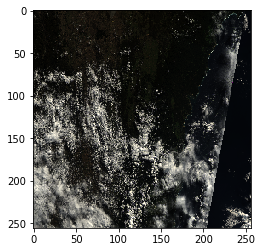

In [7]:
# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
b = nc.variables['Band1'][:]
g = nc.variables['Band2'][:]
r = nc.variables['Band3'][:]

# rgb = np.stack([nc.variables['Band%d' % (b+1)] for b in range(3)], axis=2).astype(np.float32)
rgb = np.stack([b, g, r], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()

# Uncomment next line to see the data values.
# print(rgb)

# Plot it
imgplot = plt.imshow(rgb)
plt.show()

In [8]:
# Construct a WCS call to GSKY and send it.
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=148.62%2C-35.14%2C150.83%2C-36.58&time=2013-04-04T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=fc


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


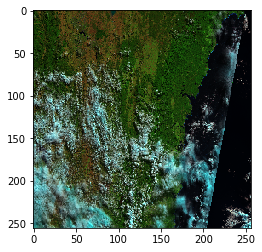

In [9]:
# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
n = nc.variables['Band1'][:]
s1 = nc.variables['Band2'][:]
s2 = nc.variables['Band3'][:]

# rgb = np.stack([nc.variables['Band%d' % (b+1)] for b in range(3)], axis=2).astype(np.float32)
rgb = np.stack([n, s1, s2], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()

# Uncomment next line to see the data values.
# print(rgb)

# Plot it
imgplot = plt.imshow(rgb)
plt.show()

In [10]:
# Compute NDVI using the formula (green - nir) / (green + nir). This will calculate 
# NDVI for every time-step in the dataset:
ds_ndwi = (g - n) / (g + n)
#ds_ndwi
wcs[layer].timepositions[t]

'2013-04-04T00:00:00.000Z'

<function matplotlib.pyplot.show(*args, **kw)>

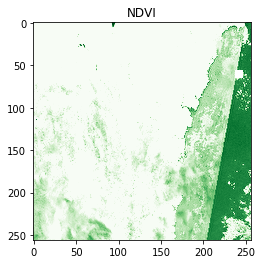

In [11]:
plt.imshow(ds_ndwi, cmap='Greens', interpolation = 'sinc', vmin = 0, vmax = 1)
plt.title('NDVI')
plt.show

#### Acknowledgements

This notebook page is derived from this [DEA notebook](https://docs.dea.ga.gov.au/notebooks/05_Temporal_analysis/SnowMonitoringUsingLandsat.html) and extensively changed to use GSKY server. Some of the text used here are directly copied from the DEA page.